Loading C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv in chunks...
Finished loading C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv - Shape: (50000, 10)
Loading C://an3.sem1//SBC.proiect//date/archive 2//House_1.csv in chunks...
Finished loading C://an3.sem1//SBC.proiect//date/archive 2//House_1.csv - Shape: (50000, 12)
Loading C://an3.sem1//SBC.proiect//date/archive 2//House_2.csv in chunks...
Finished loading C://an3.sem1//SBC.proiect//date/archive 2//House_2.csv - Shape: (50000, 12)


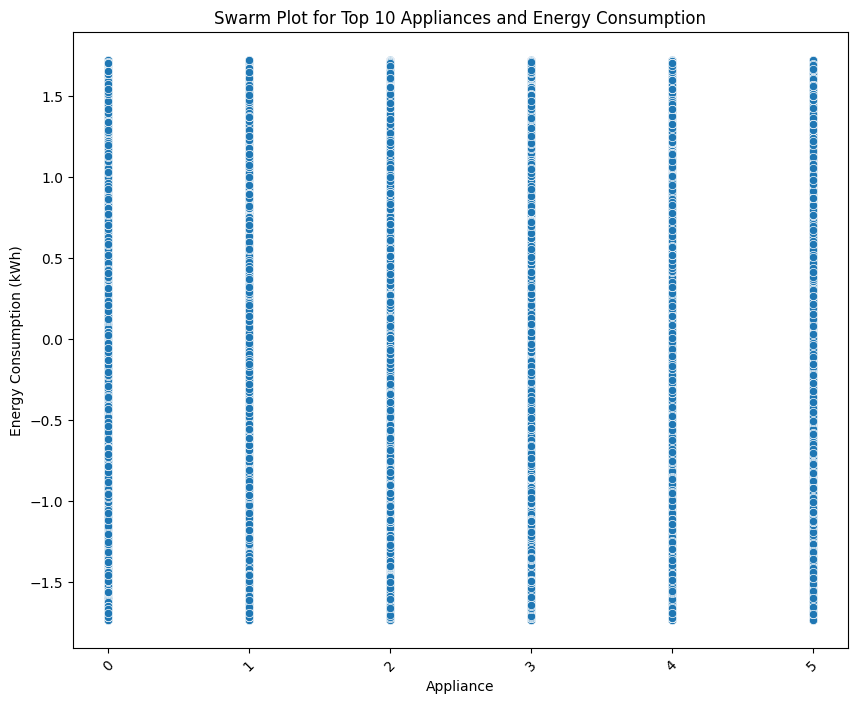

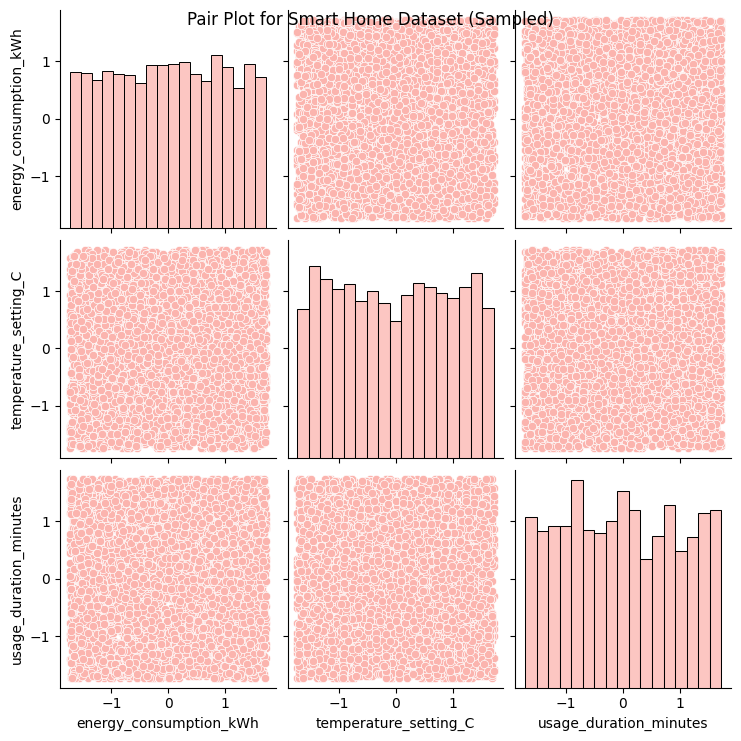

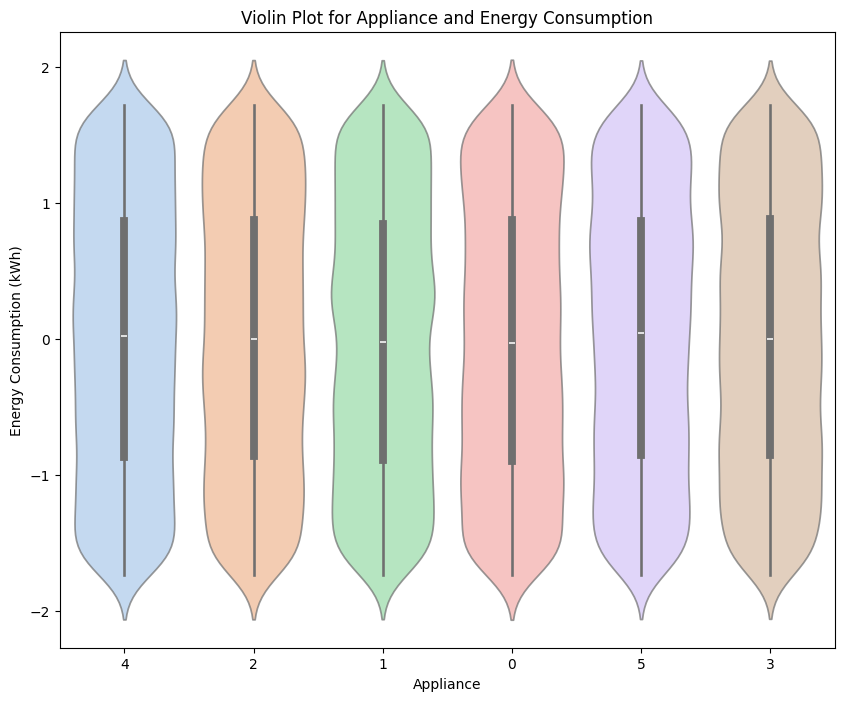

Smart_home Dataset after cleaning:
            timestamp  home_id  energy_consumption_kWh  temperature_setting_C  \
0 2023-01-01 00:00:00       44                0.219513               0.720377   
1 2023-01-01 01:00:00       81               -1.409876              -1.593972   
2 2023-01-01 02:00:00       94                1.362202               0.824004   
3 2023-01-01 03:00:00       20               -0.302455               1.583939   
4 2023-01-01 04:00:00        3                0.127816               0.478579   

   occupancy_status appliance  usage_duration_minutes  season  day_of_week  \
0                 0         4                1.495792       1            3   
1                 0         2                1.263939       2            3   
2                 0         1               -1.373388       0            3   
3                 1         0               -0.156160       0            3   
4                 1         2               -1.547277       2            3   

   holida

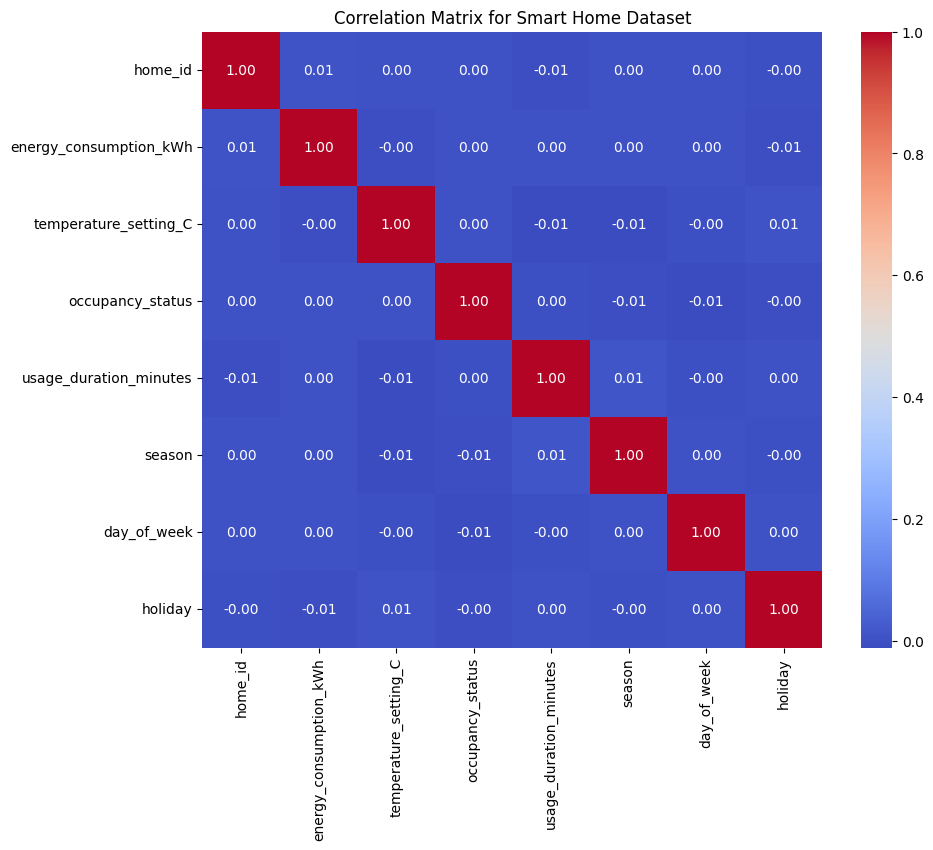

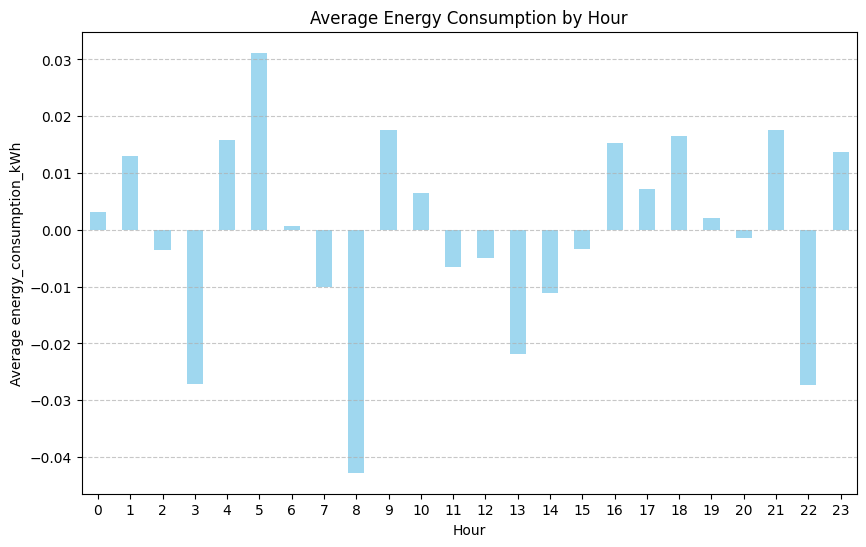

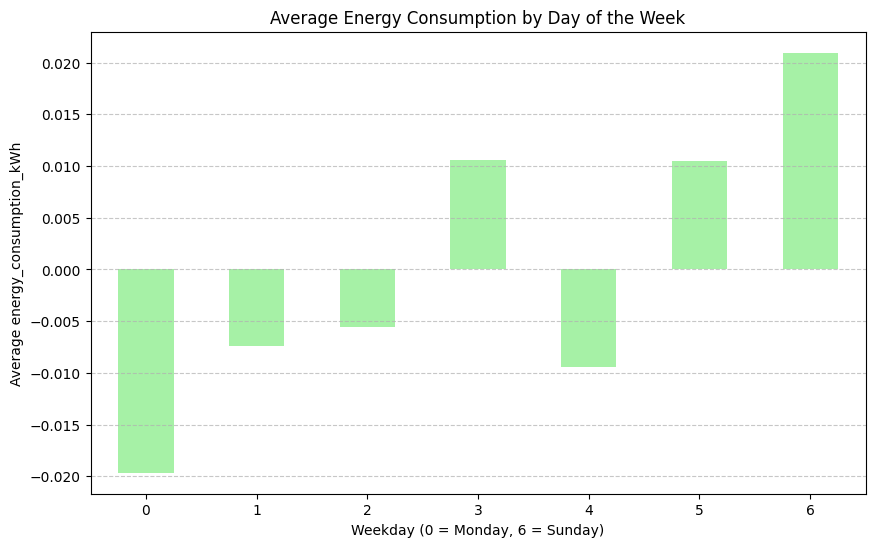

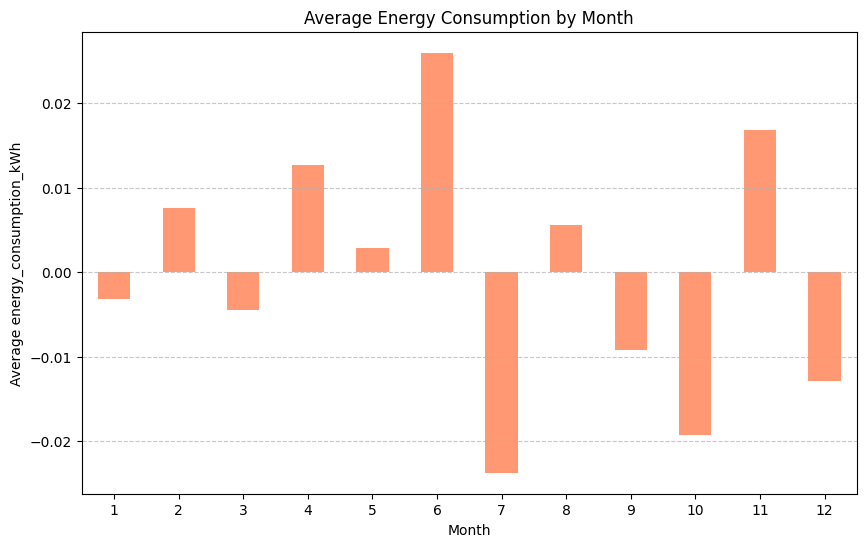

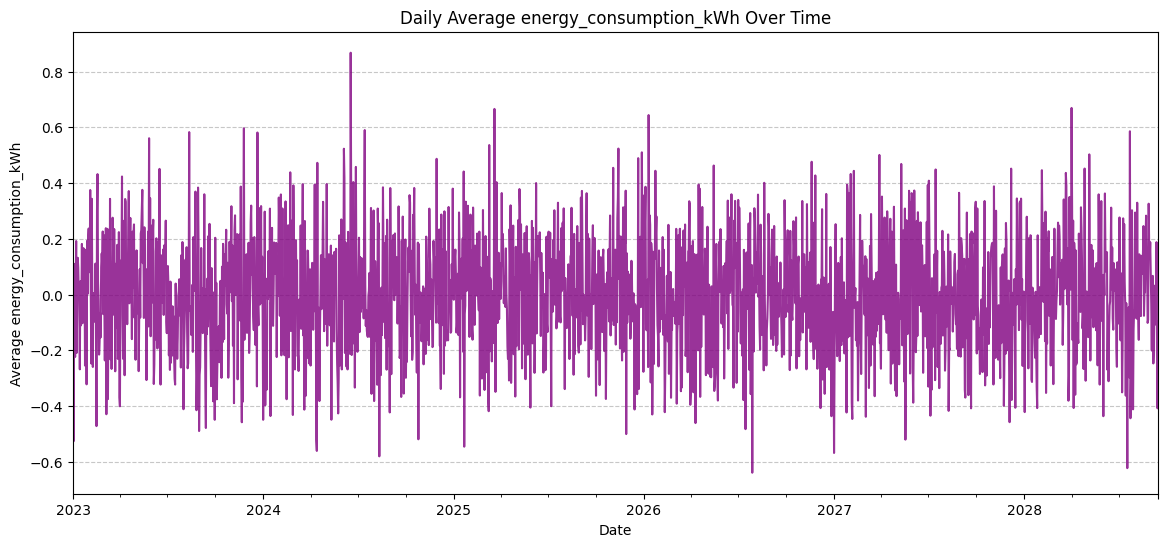

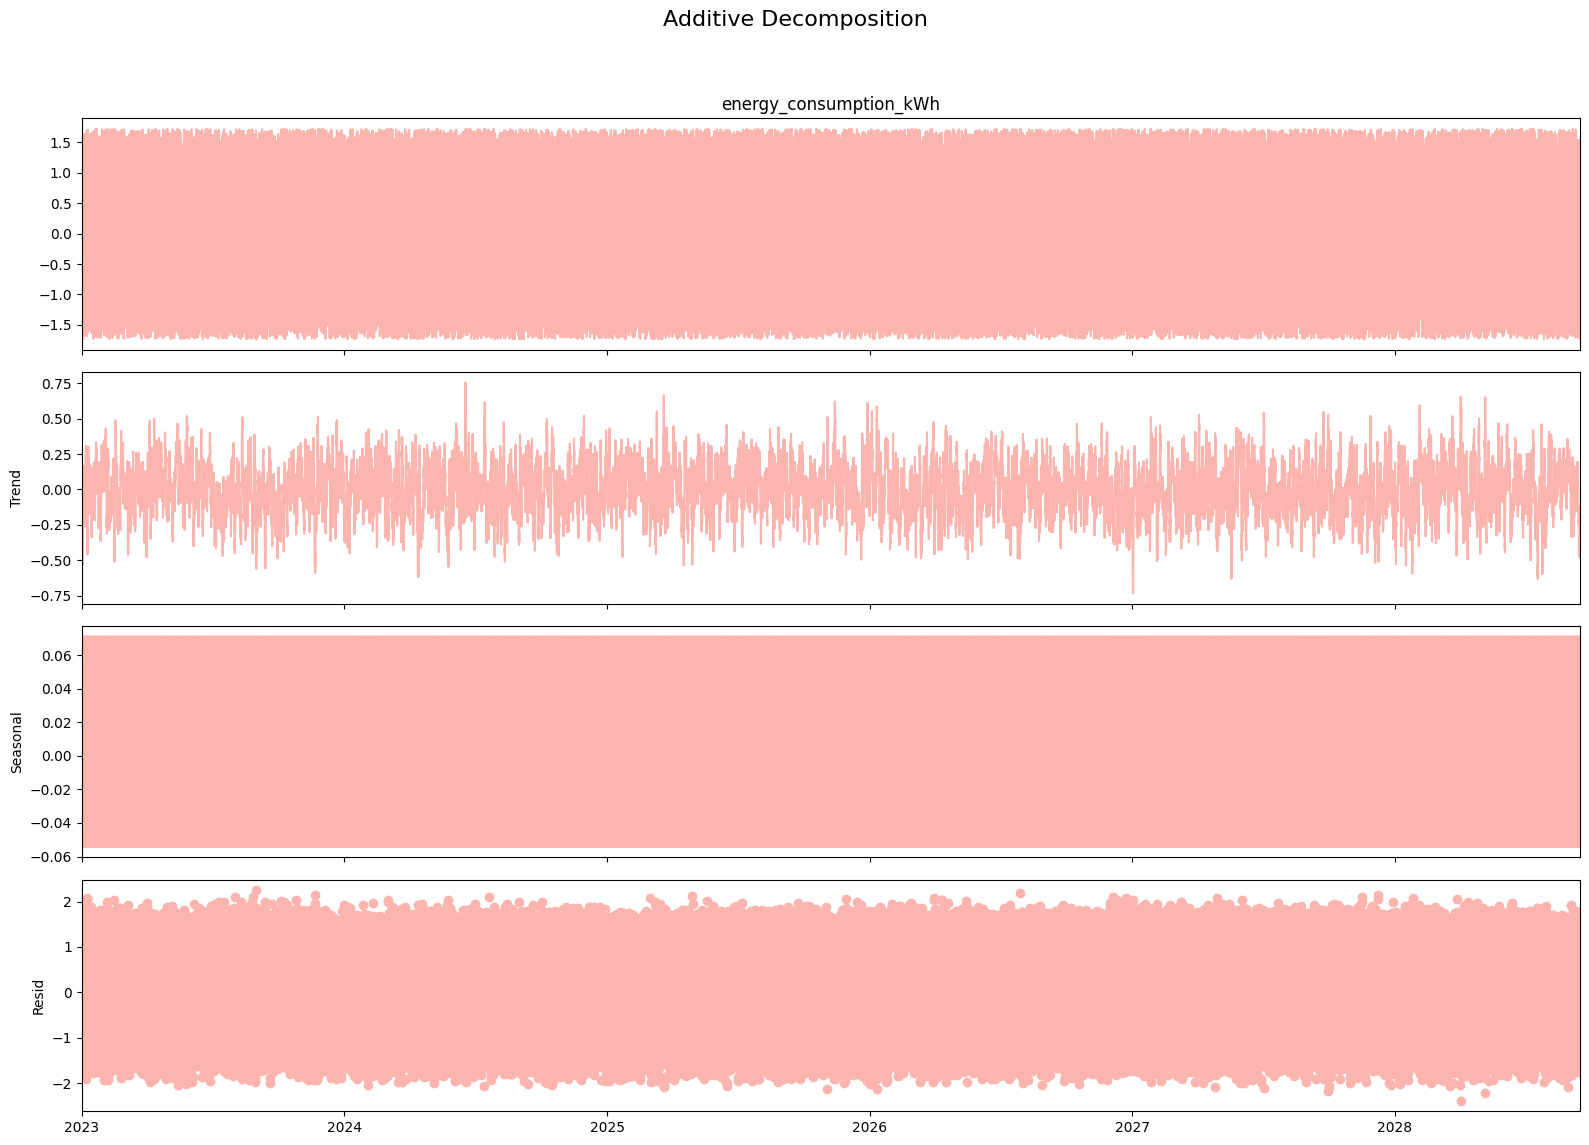

Columns in dataset: Index(['timestamp', 'home_id', 'energy_consumption_kWh',
       'temperature_setting_C', 'occupancy_status', 'appliance',
       'usage_duration_minutes', 'season', 'day_of_week', 'holiday'],
      dtype='object')

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8174  , p=0.3660  , df_denom=999996, df_num=1
ssr based chi2 test:   chi2=0.8174  , p=0.3660  , df=1
likelihood ratio test: chi2=0.8174  , p=0.3660  , df=1
parameter F test:         F=0.8174  , p=0.3660  , df_denom=999996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7376  , p=0.4783  , df_denom=999993, df_num=2
ssr based chi2 test:   chi2=1.4752  , p=0.4783  , df=2
likelihood ratio test: chi2=1.4752  , p=0.4783  , df=2
parameter F test:         F=0.7376  , p=0.4783  , df_denom=999993, df_num=2


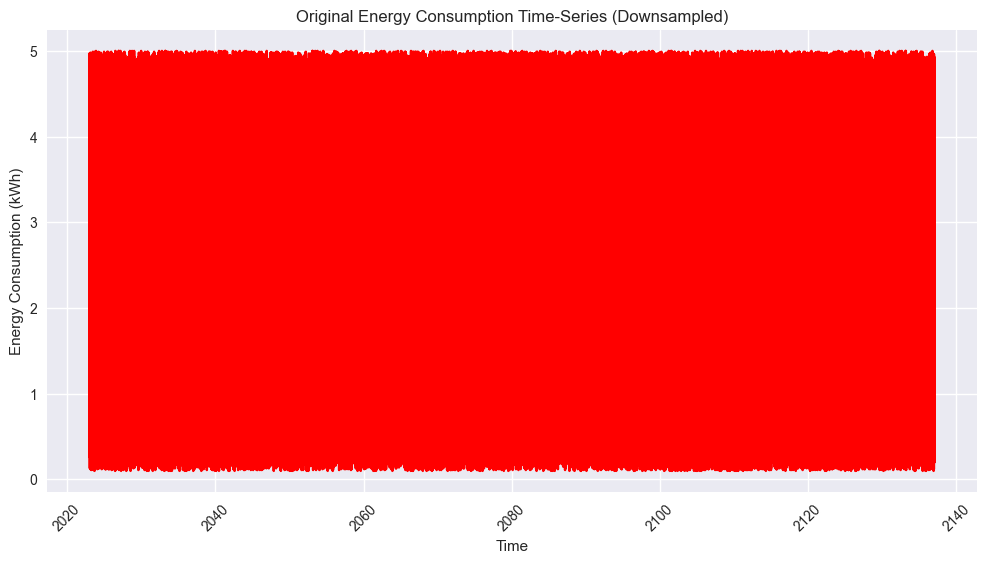

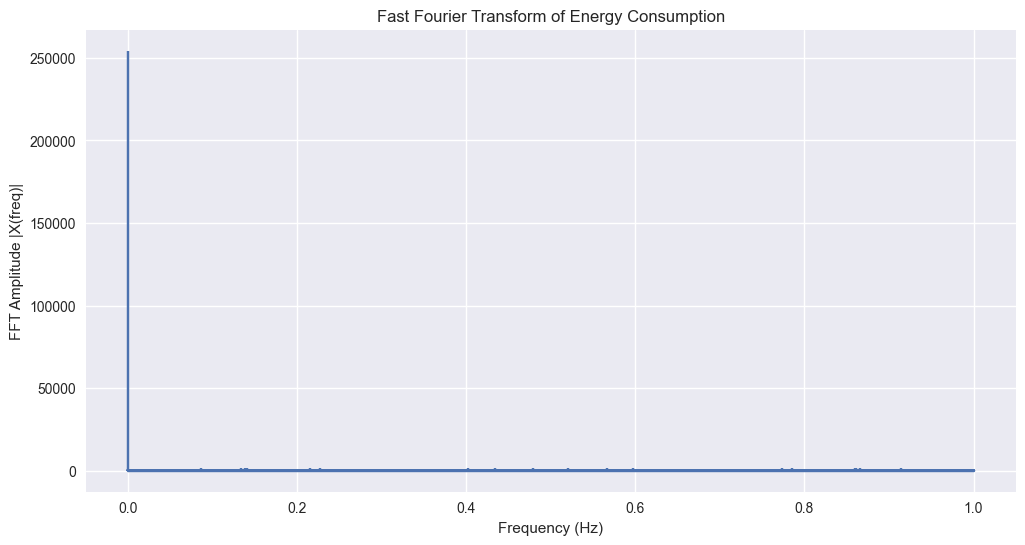

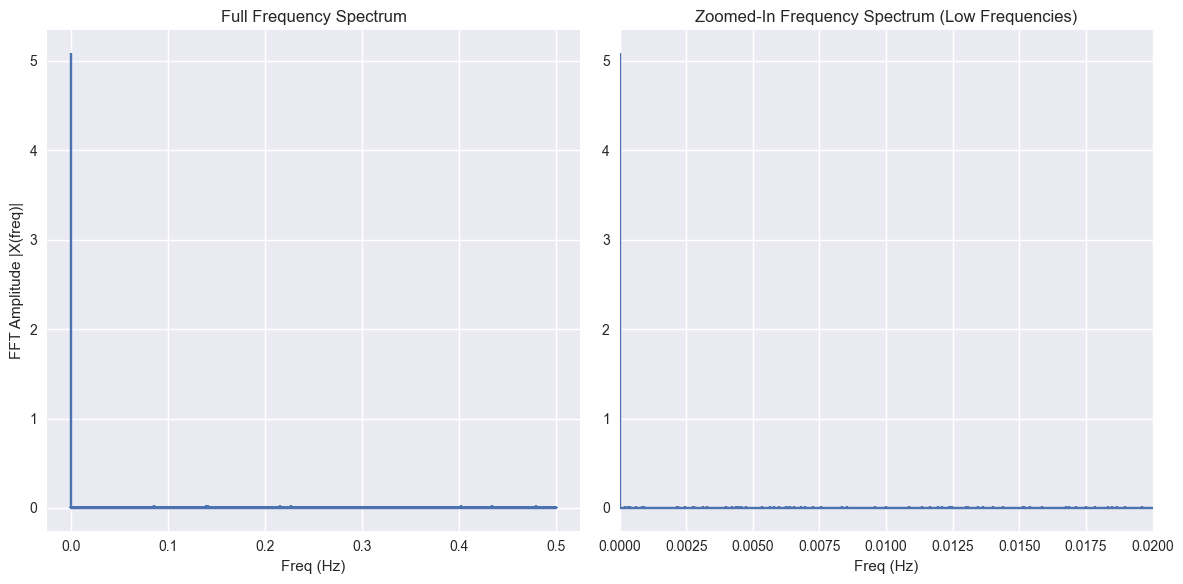

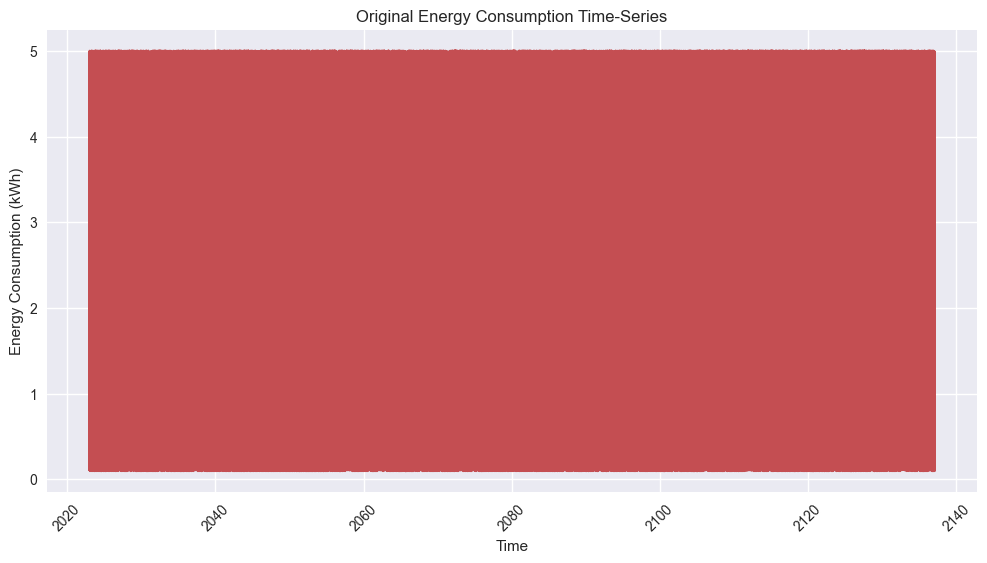

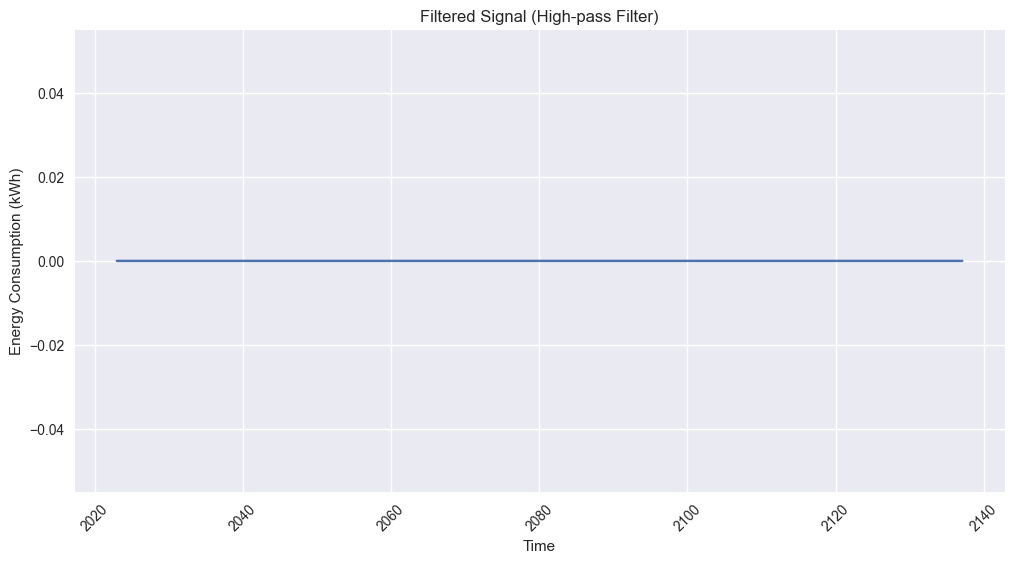

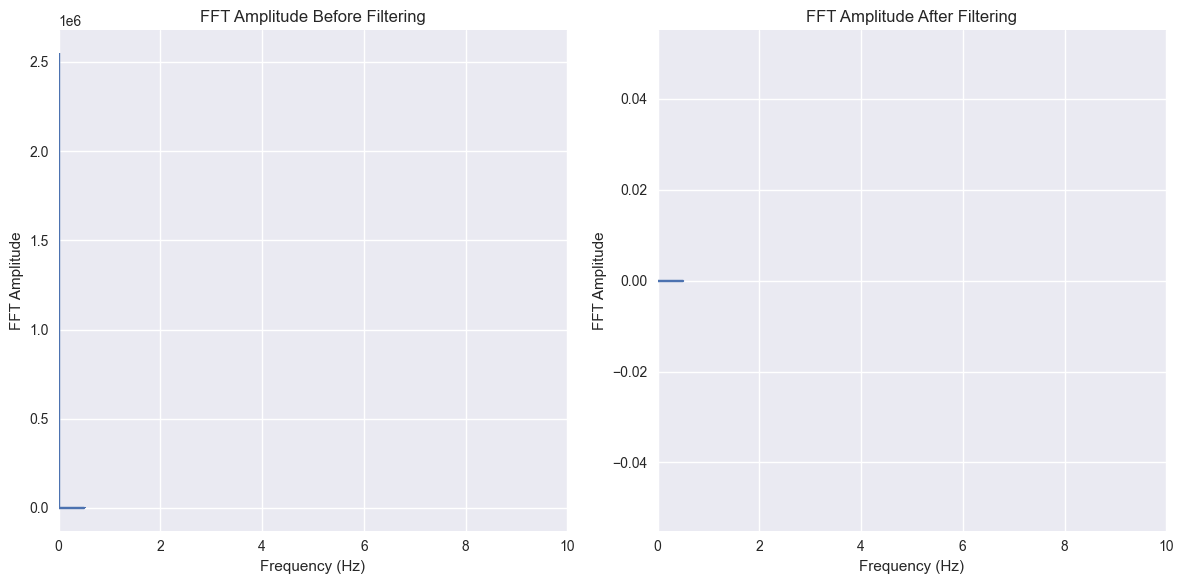

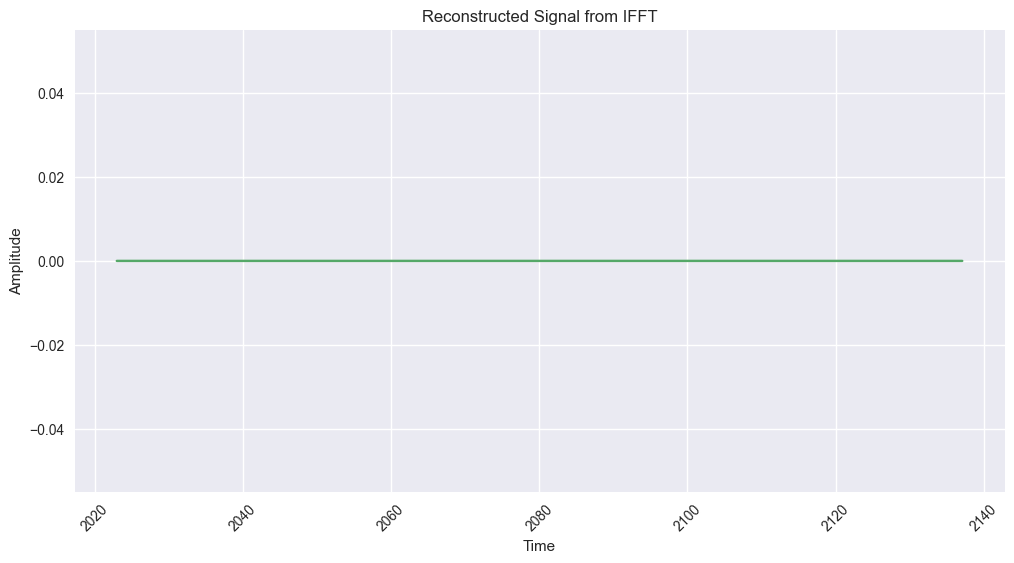

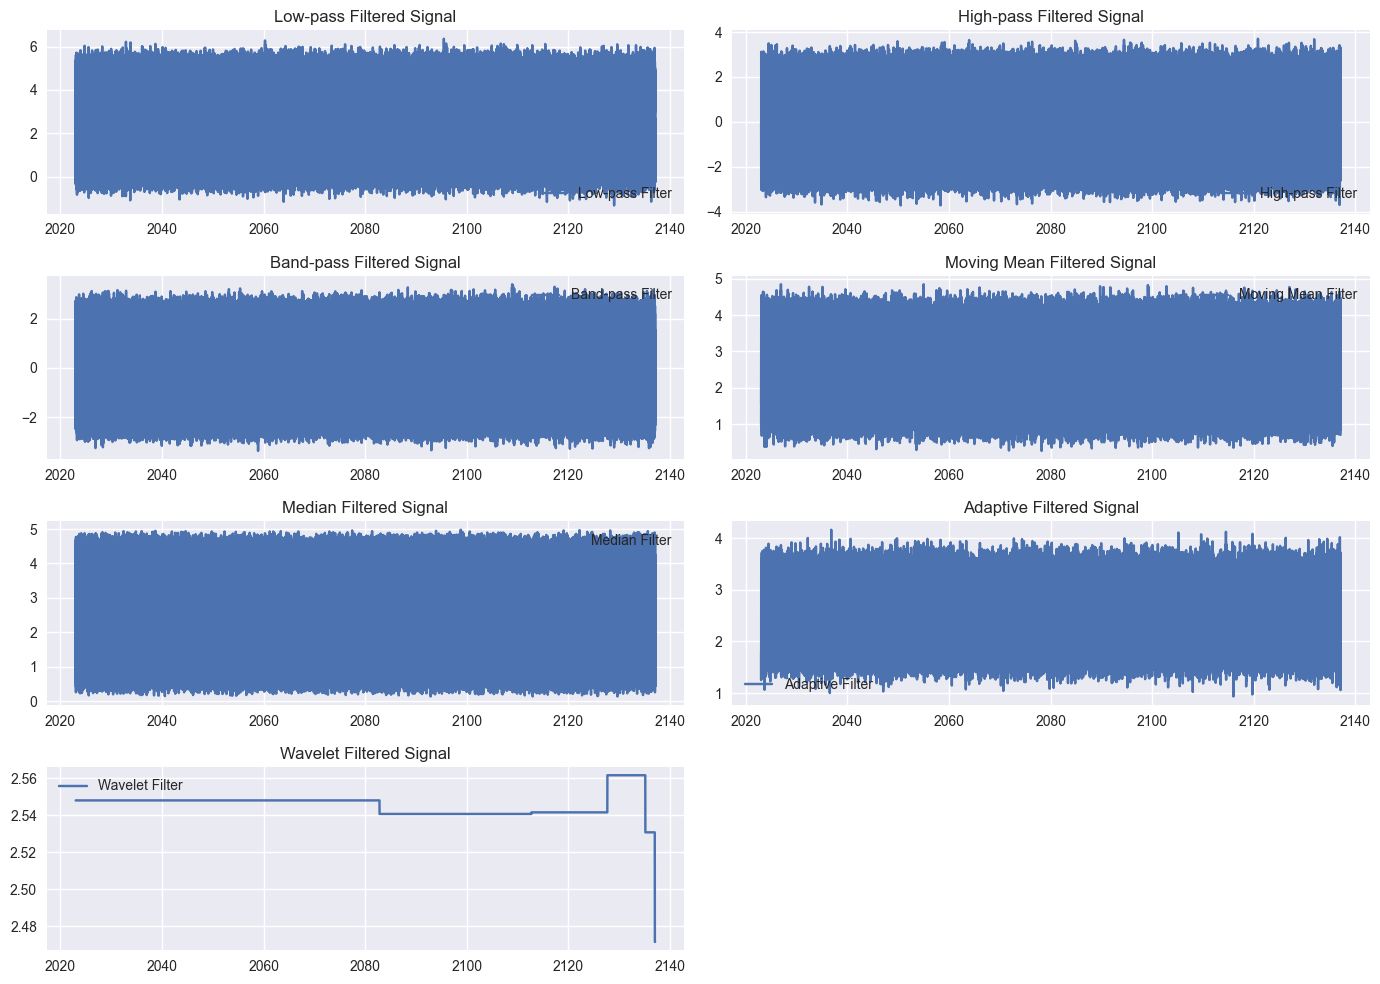

Index(['timestamp', 'home_id', 'energy_consumption_kWh',
       'temperature_setting_C', 'occupancy_status', 'appliance',
       'usage_duration_minutes', 'season', 'day_of_week', 'holiday'],
      dtype='object')


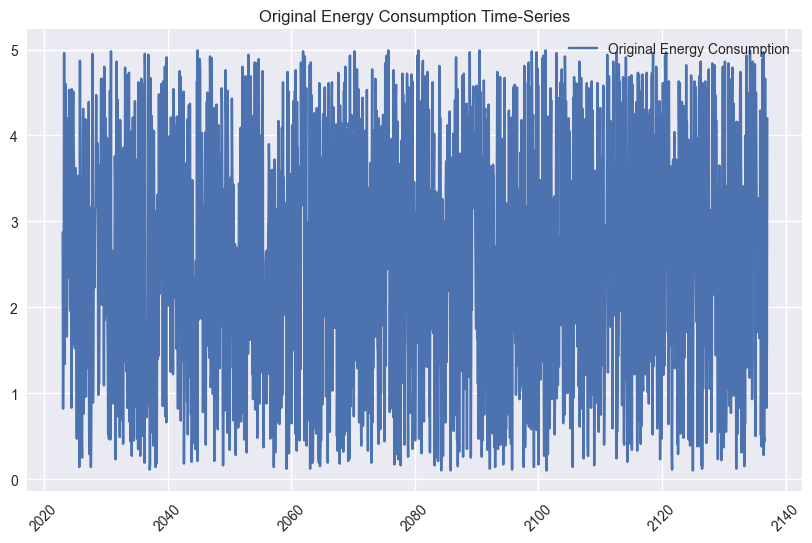

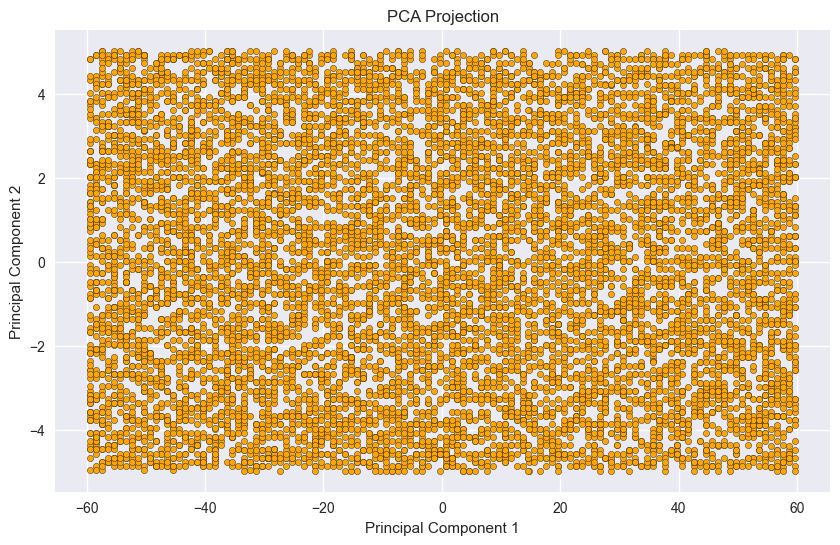

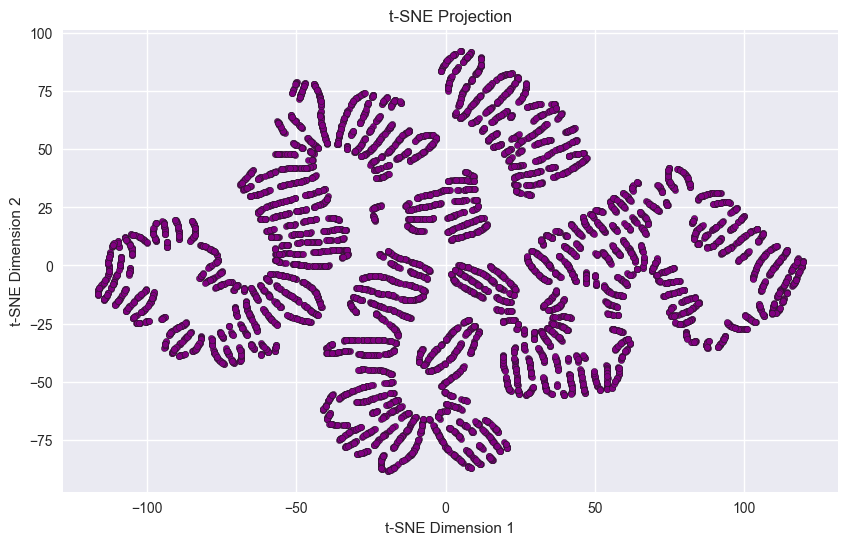

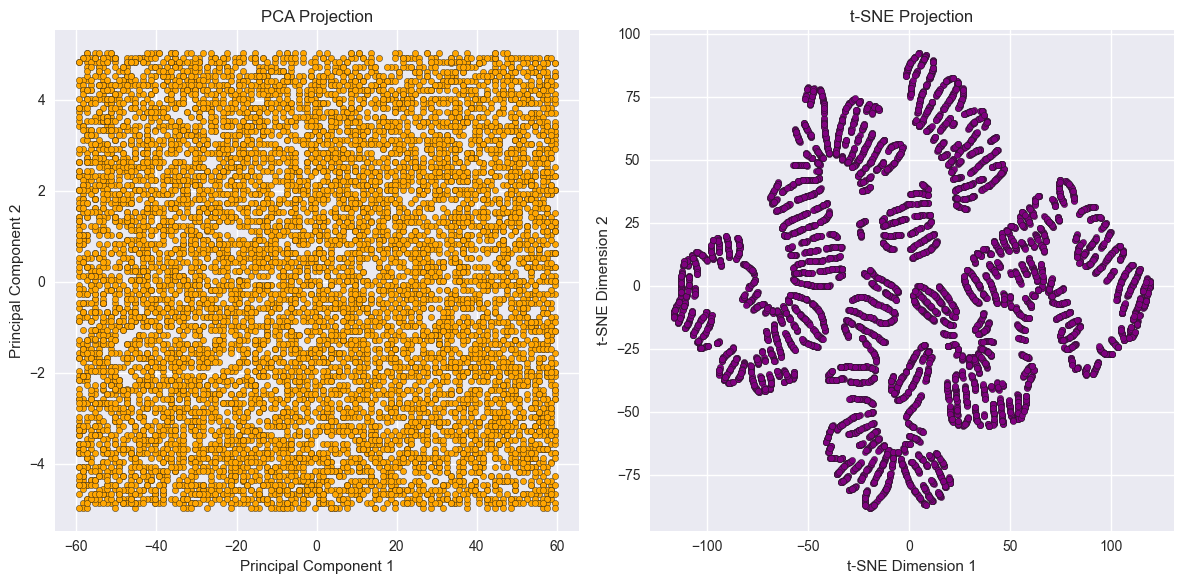

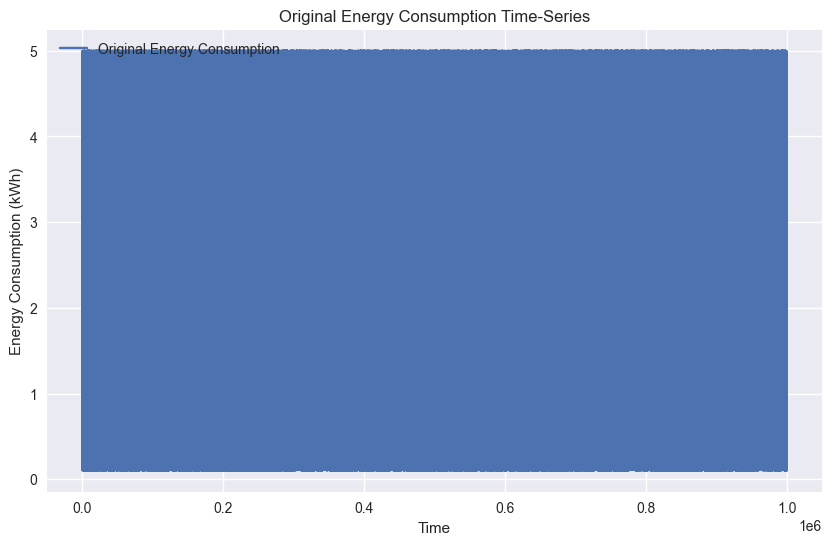

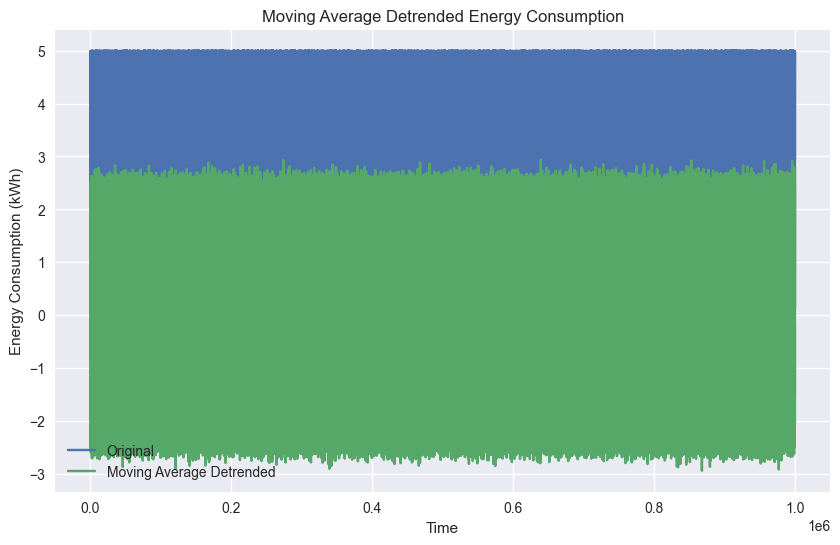

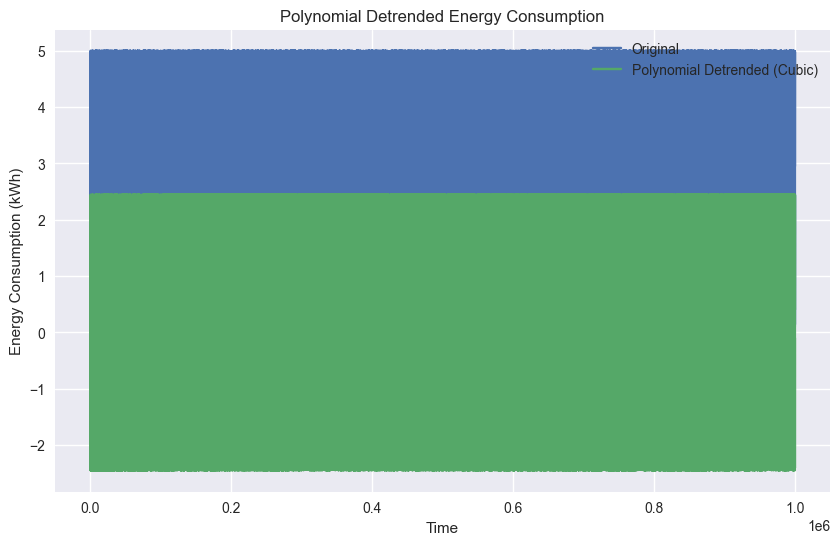

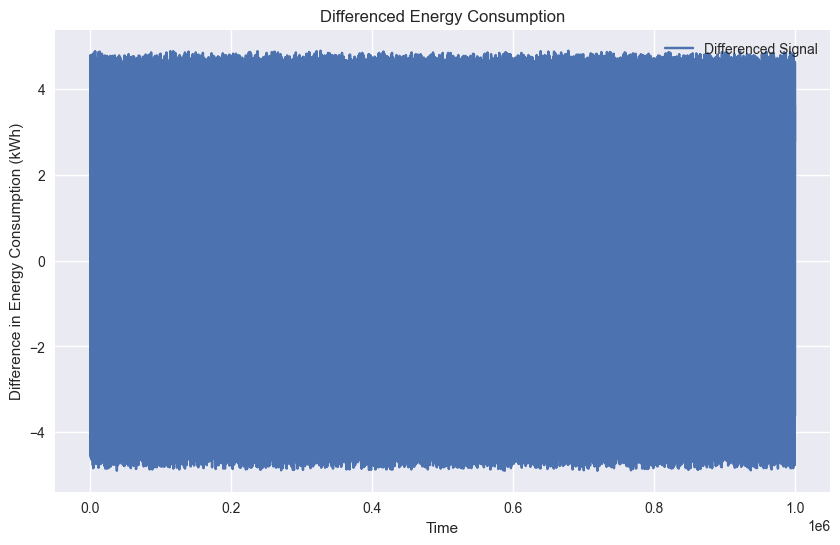

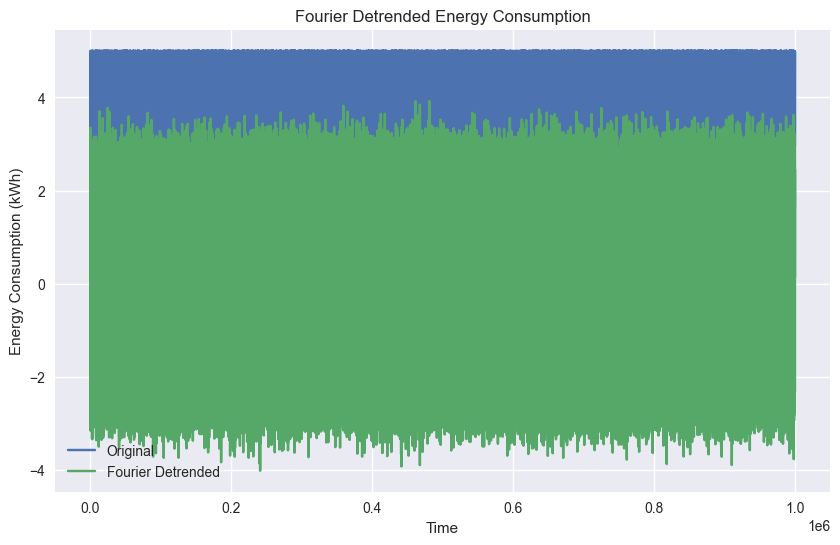

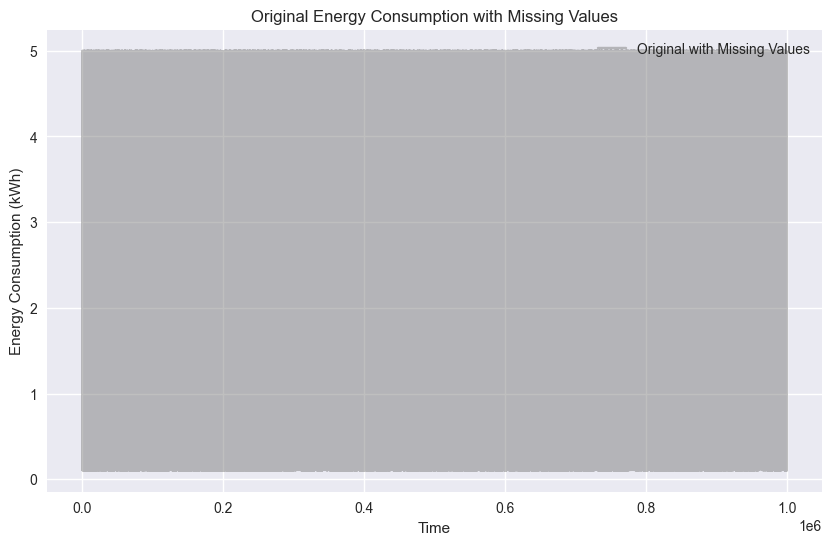

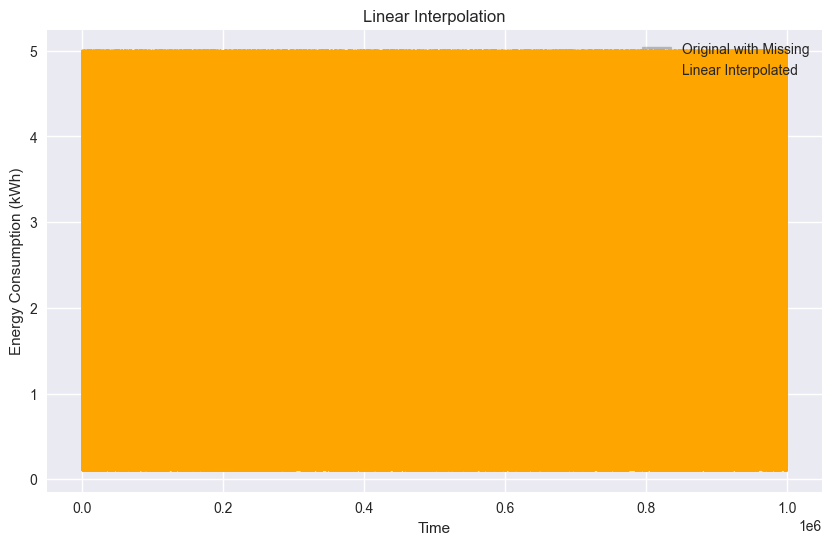

Statistical Features of Selected Sensors:
                             mean        std   min    max
energy_consumption_kWh   2.548839   1.415527   0.1    5.0
temperature_setting_C   19.999284   2.887678  15.0   25.0
usage_duration_minutes  59.505089  34.651890   0.0  119.0


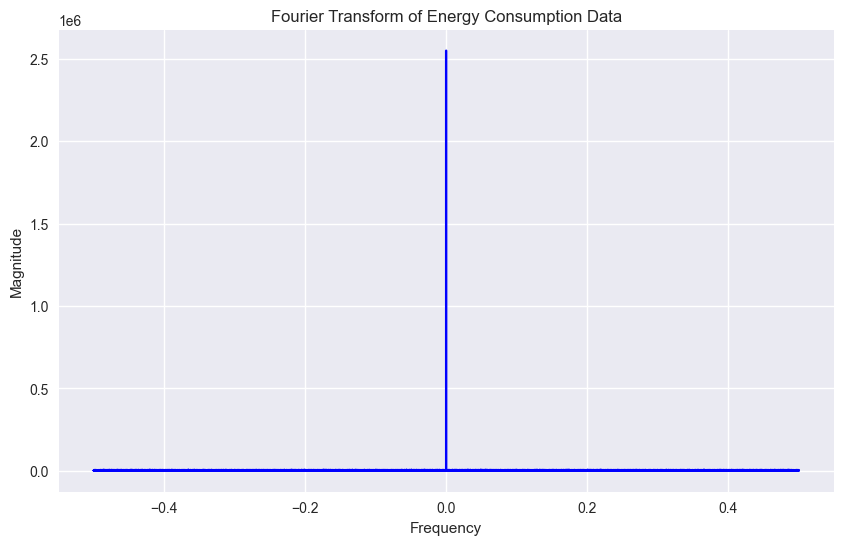

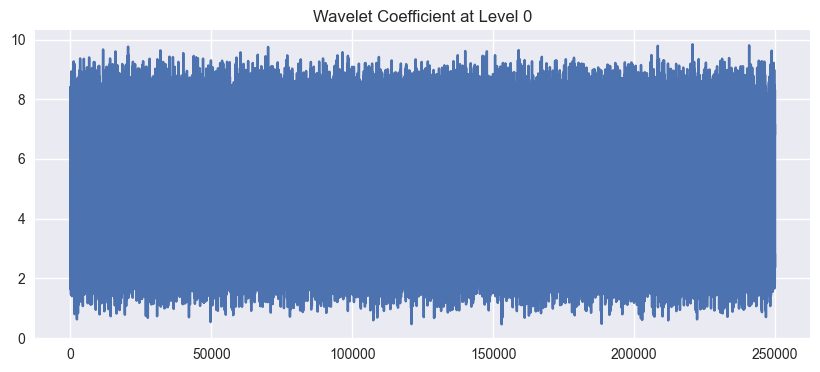

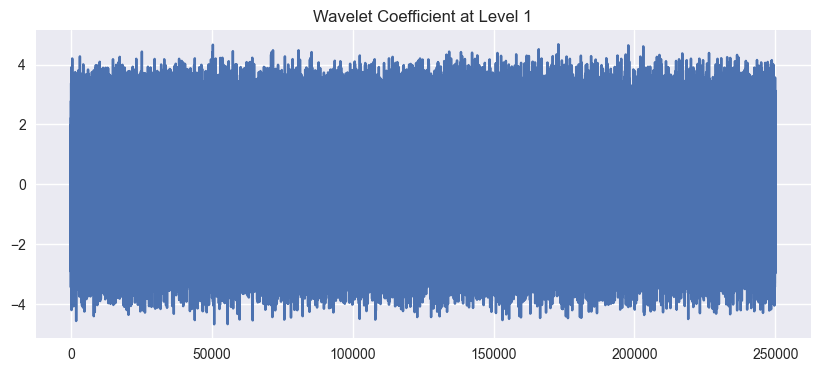

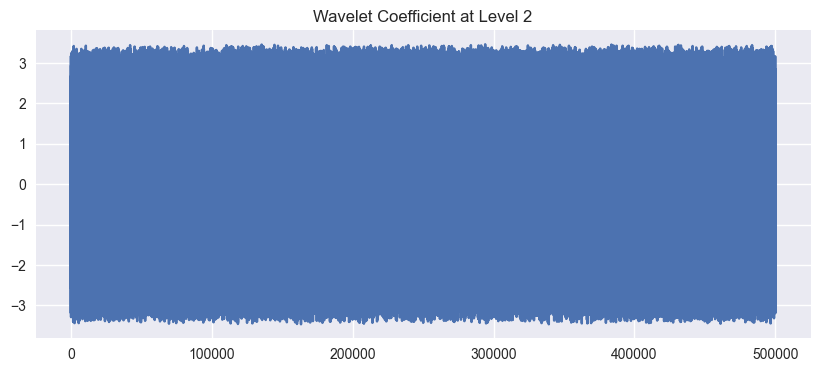

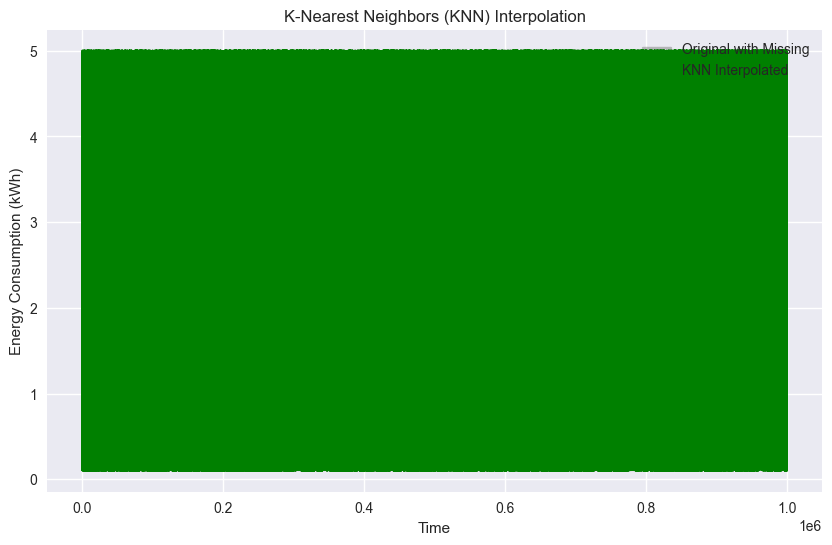

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wr
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
wr.filterwarnings('ignore')

# Step 2: Reading Datasets with Chunking
# Loading and reading datasets with memory optimization
file_paths = {
    "smart_home": "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv",
    "house_1": "C://an3.sem1//SBC.proiect//date/archive 2//House_1.csv",
    "house_2": "C://an3.sem1//SBC.proiect//date/archive 2//House_2.csv"
}

chunk_size = 50000  # Define chunk size

def load_csv_partial(file_path, chunk_size):
    if not os.path.exists(file_path):
        print(f"Error: File not found - {file_path}")
        return None
    
    print(f"Loading {file_path} in chunks...")
    df_chunk = pd.read_csv(file_path, chunksize=chunk_size, low_memory=False)
    df = next(df_chunk)
    print(f"Finished loading {file_path} - Shape: {df.shape}")
    return df

datasets = {name: load_csv_partial(path, chunk_size) for name, path in file_paths.items()}

# Data Cleaning
for name, df in datasets.items():
    if df is not None:
        time_col = "timestamp" if name == "smart_home" else "Time"
        df[time_col] = pd.to_datetime(df[time_col])
        df.drop_duplicates(inplace=True)

# Standardize categorical columns for smart_home
categorical_cols = ["appliance", "season", "day_of_week", "occupancy_status"]
for col in categorical_cols:
    datasets["smart_home"][col] = datasets["smart_home"][col].str.lower().str.strip()

# Remove outliers using IQR method
num_cols = ["energy_consumption_kWh", "temperature_setting_C", "usage_duration_minutes"]
for col in num_cols:
    Q1, Q3 = datasets["smart_home"][col].quantile(0.25), datasets["smart_home"][col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    datasets["smart_home"] = datasets["smart_home"][(datasets["smart_home"][col] >= lower_bound) & 
                                                       (datasets["smart_home"][col] <= upper_bound)]

# Normalize numerical features
scaler = StandardScaler()
datasets["smart_home"][num_cols] = scaler.fit_transform(datasets["smart_home"][num_cols])

# Encode categorical features
encoder = LabelEncoder()
for col in categorical_cols:
    datasets["smart_home"][col] = encoder.fit_transform(datasets["smart_home"][col])

# Data Visualization
# Swarm Plot for Appliance vs Energy Consumption
plt.figure(figsize=(10, 8))
top_appliances = datasets["smart_home"]["appliance"].value_counts().nlargest(10).index
df_filtered = datasets["smart_home"][datasets["smart_home"]["appliance"].isin(top_appliances)]
sns.scatterplot(x="appliance", y="energy_consumption_kWh", data=df_filtered, palette='viridis')
plt.title('Swarm Plot for Top 10 Appliances and Energy Consumption')
plt.xlabel('Appliance')
plt.ylabel('Energy Consumption (kWh)')
plt.xticks(rotation=45)
plt.show()

# Pair Plot for Numerical Features
sns.set_palette("Pastel1")
df_sample = datasets["smart_home"].sample(min(5000, len(datasets["smart_home"])), random_state=42)
sns.pairplot(df_sample[num_cols])
plt.suptitle('Pair Plot for Smart Home Dataset (Sampled)')
plt.show()

# Violin Plot for Appliance vs Energy Consumption
plt.figure(figsize=(10, 8))
datasets["smart_home"]['appliance'] = datasets["smart_home"]['appliance'].astype(str)
sns.violinplot(x="appliance", y="energy_consumption_kWh", data=datasets["smart_home"], palette='pastel', alpha=0.7)
plt.title('Violin Plot for Appliance and Energy Consumption')
plt.xlabel('Appliance')
plt.ylabel('Energy Consumption (kWh)')
plt.show()

# Display cleaned data
for name, df in datasets.items():
    if df is not None:
        print(f"{name.capitalize()} Dataset after cleaning:")
        print(df.head())
# Compute correlation matrix
correlation_matrix = datasets["smart_home"].corr()


# Importing Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'datasets["smart_home"]' contains the cleaned dataset
# Ensure it includes only numerical columns for correlation analysis
numerical_cols = datasets["smart_home"].select_dtypes(include=["float64", "int64"]).columns

# Compute the correlation matrix
correlation_matrix = datasets["smart_home"][numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix for Smart Home Dataset")
plt.show()

# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings as wr
wr.filterwarnings('ignore')

# Function for Temporal Analysis (EDA)
def temporal_analysis(df, time_col, value_col):
    # Ensure the time column is in datetime format
    df[time_col] = pd.to_datetime(df[time_col])

    # Extract temporal features
    df['hour'] = df[time_col].dt.hour
    df['day'] = df[time_col].dt.day
    df['month'] = df[time_col].dt.month
    df['weekday'] = df[time_col].dt.weekday

    # Energy consumption by hour
    hourly_avg = df.groupby('hour')[value_col].mean()
    plt.figure(figsize=(10, 6))
    hourly_avg.plot(kind='bar', color='skyblue', alpha=0.8)
    plt.title('Average Energy Consumption by Hour')
    plt.xlabel('Hour')
    plt.ylabel(f'Average {value_col}')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Energy consumption by day of the week
    weekday_avg = df.groupby('weekday')[value_col].mean()
    plt.figure(figsize=(10, 6))
    weekday_avg.plot(kind='bar', color='lightgreen', alpha=0.8)
    plt.title('Average Energy Consumption by Day of the Week')
    plt.xlabel('Weekday (0 = Monday, 6 = Sunday)')
    plt.ylabel(f'Average {value_col}')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Monthly energy consumption
    monthly_avg = df.groupby('month')[value_col].mean()
    plt.figure(figsize=(10, 6))
    monthly_avg.plot(kind='bar', color='coral', alpha=0.8)
    plt.title('Average Energy Consumption by Month')
    plt.xlabel('Month')
    plt.ylabel(f'Average {value_col}')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Energy consumption over time (trend)
    plt.figure(figsize=(14, 6))
    df.set_index(time_col)[value_col].resample('D').mean().plot(color='purple', alpha=0.8)
    plt.title(f'Daily Average {value_col} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'Average {value_col}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Function for Time Series Decomposition
def time_series_decomposition(df, time_col, value_col, freq=30):
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.set_index(time_col)
    series = df[value_col]

    # Check for zero or negative values
    if any(series <= 0):
        print("Warning: Found zero or negative values. Switching to additive decomposition.")
        additive_decomposition = seasonal_decompose(series, model='additive', period=freq)
        plt.rcParams.update({'figure.figsize': (16, 12)})
        additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        # Multiplicative Decomposition
        multiplicative_decomposition = seasonal_decompose(series, model='multiplicative', period=freq)
        # Additive Decomposition
        additive_decomposition = seasonal_decompose(series, model='additive', period=freq)

        # Plot decompositions
        plt.rcParams.update({'figure.figsize': (16, 12)})
        multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Example: Applying Both Methods to Smart Home Dataset
temporal_analysis(datasets["smart_home"], time_col="timestamp", value_col="energy_consumption_kWh")
time_series_decomposition(datasets["smart_home"], time_col="timestamp", value_col="energy_consumption_kWh", freq=30)
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings as wr
wr.filterwarnings('ignore')

# Function for Detrending and Deseasonalizing Time Series
def time_series_detrend_deseasonalize(df, time_col, value_col, freq=30):
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.set_index(time_col)
    series = df[value_col]

    # Ensure all values are positive for multiplicative decomposition
    if any(series <= 0):
        print("Warning: Found zero or negative values. Switching to additive decomposition.")
        decomposition_model = 'additive'
    else:
        decomposition_model = 'multiplicative'

    # Detrending using Scipy - Removing line of best fit
    detrended = signal.detrend(series.values)
    plt.figure(figsize=(10, 5))
    plt.plot(detrended, color='blue')
    plt.title(f'{value_col} detrended by subtracting the least squares fit')
    plt.show()

    # Detrending using seasonal decomposition
    result_decomp = seasonal_decompose(series, model=decomposition_model, period=freq)
    detrended = series - result_decomp.trend
    plt.figure(figsize=(10, 5))
    plt.plot(detrended, color='red')
    plt.title(f'{value_col} detrended by subtracting the trend component')
    plt.show()

    # Deseasonalizing
    deseasonalized = series / result_decomp.seasonal
    plt.figure(figsize=(10, 5))
    plt.plot(deseasonalized, color='green')
    plt.title(f'{value_col} Deseasonalized')
    plt.show()

    # Autocorrelation plot to check seasonality
    plt.figure(figsize=(10, 5))
    autocorrelation_plot(series)
    plt.title(f'Autocorrelation Plot of {value_col}')
    plt.show()

    # ACF and PACF plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 4), dpi=100)
    plot_acf(series, lags=50, ax=axes[0])
    plot_pacf(series, lags=50, ax=axes[1])
    axes[0].set_title(f'Autocorrelation Function (ACF) - {value_col}')
    axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {value_col}')
    plt.show()

# Lag Plots
def plot_lag_plots(df, value_col):
    plt.rcParams.update({'ytick.left': False, 'axes.titlepad': 10})
    fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True, dpi=100)
    for i, ax in enumerate(axes.flatten()[:4]):
        lag_plot(df[value_col], lag=i+1, ax=ax, c='firebrick')
        ax.set_title(f'Lag {i+1}')
    fig.suptitle(f'Lag Plots of {value_col}', y=1.05)
    plt.show()

# Granger Causality Test
def granger_causality_test(file_path):
    if not os.path.exists(file_path):
        print(f"Error: File not found - {file_path}")
        return
    
    data = pd.read_csv(file_path)
    print("Columns in dataset:", data.columns)
    
    # Verifică dacă timestamp este în dataset și îl folosește în loc de "date"
    if 'timestamp' not in data.columns:
        print("Error: 'timestamp' column not found. Available columns:", data.columns)
        return
    
    if 'energy_consumption_kWh' not in data.columns:
        print("Error: 'energy_consumption_kWh' column not found. Available columns:", data.columns)
        return
    
    # Convert timestamp to datetime format
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    # Extract month
    data['month'] = data['timestamp'].dt.month
    
    # Granger Causality Test
    grangercausalitytests(data[['energy_consumption_kWh', 'month']], maxlag=2)

# Apply function to Smart Home Dataset
granger_causality_test(r"C:\\an3.sem1\\SBC.proiect\\date\\archive 1\\smart_home_energy_usage_dataset.csv")
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft

# Set Seaborn style
sns.set()
plt.style.use('seaborn-v0_8')

# Load dataset
file_path = "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv"
df = pd.read_csv(file_path)

# Ensure timestamp is in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values(by="timestamp")

# Reduce dataset size (Downsampling)
df_sampled = df.iloc[::10, :]  # Keep every 10th row to reduce memory usage

# Select time-series data
time_series = df_sampled["energy_consumption_kWh"].values
N = len(time_series)  # Number of data points
T = N / 1  # Assuming data is hourly, T is total duration

# Plot original energy consumption data
plt.figure(figsize=(12, 6))
plt.plot(df_sampled["timestamp"], time_series, color='red')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Original Energy Consumption Time-Series (Downsampled)')
plt.xticks(rotation=45)
plt.show()

# Apply Fast Fourier Transform (FFT)
X = fft(time_series)

# Compute frequency axis
n = np.arange(N)
freq = n / T  # Frequency in Hz

# Plot the FFT magnitude spectrum
plt.figure(figsize=(12, 6))
plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('Fast Fourier Transform of Energy Consumption')
plt.show()

# Extract one-sided frequency spectrum
n_oneside = N // 2
f_oneside = freq[:n_oneside]
X_oneside = X[:n_oneside] / n_oneside  # Normalize amplitude

# Plot one-sided frequency spectrum
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.stem(f_oneside, abs(X_oneside), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.title('Full Frequency Spectrum')

plt.subplot(122)
plt.stem(f_oneside, abs(X_oneside), 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.xlim(0, 0.02)  # Adjust the zoom for low frequencies
plt.title('Zoomed-In Frequency Spectrum (Low Frequencies)')

plt.tight_layout()
plt.show()

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.fft import fft, ifft
from scipy.fftpack import fftfreq

# Load dataset
file_path = "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv"
df = pd.read_csv(file_path)

# Ensure timestamp is in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values(by="timestamp")

# Select time-series data
time_series = df["energy_consumption_kWh"].values
N = len(time_series)  # Number of data points
sr = 1  # Assuming data is hourly
T = N / sr  # Total duration
n = np.arange(N)

# Apply FFT
sig_fft = fft(time_series)
freq = fftfreq(N, d=1./sr)  # Compute frequencies

# Define the cutoff frequency for high-pass filter
cut_off = 6  # Cut-off frequency in Hz

# Apply high-pass filter by zeroing out low frequencies
sig_fft_filtered = sig_fft.copy()
sig_fft_filtered[np.abs(freq) < cut_off] = 0

# Inverse FFT to get the filtered signal in the time domain
filtered = ifft(sig_fft_filtered).real

# Plot original signal
plt.figure(figsize=(12, 6))
plt.plot(df["timestamp"], time_series, 'r')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Original Energy Consumption Time-Series')
plt.xticks(rotation=45)
plt.show()

# Plot filtered signal
plt.figure(figsize=(12, 6))
plt.plot(df["timestamp"], filtered, 'b')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Filtered Signal (High-pass Filter)')
plt.xticks(rotation=45)
plt.show()

# Plot FFT amplitude before and after filtering
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.stem(freq, np.abs(sig_fft), 'b', markerfmt=" ", basefmt="-b")
plt.title('FFT Amplitude Before Filtering')
plt.xlim(0, 10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')

plt.subplot(122)
plt.stem(freq, np.abs(sig_fft_filtered), 'b', markerfmt=" ", basefmt="-b")
plt.title('FFT Amplitude After Filtering')
plt.xlim(0, 10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude')

plt.tight_layout()
plt.show()

# Plot reconstructed signal from IFFT
plt.figure(figsize=(12, 6))
plt.plot(df["timestamp"], ifft(sig_fft_filtered).real, 'g')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Reconstructed Signal from IFFT')
plt.xticks(rotation=45)
plt.show()


import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.fft import fft, ifft
from scipy.fftpack import fftfreq
from scipy import signal
from scipy.ndimage import median_filter
import pywt

# Load dataset
file_path = "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv"
df = pd.read_csv(file_path)

# Ensure timestamp is in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values(by="timestamp")

# Select time-series data
time_series = df["energy_consumption_kWh"].values
N = len(time_series)  # Number of data points
sr = 1  # Assuming data is hourly
T = N / sr  # Total duration
n = np.arange(N)

# Apply FFT
sig_fft = fft(time_series)
freq = fftfreq(N, d=1./sr)  # Compute frequencies

# Define the cutoff frequency for high-pass filter
cut_off = 6  # Cut-off frequency in Hz

# Apply high-pass filter by zeroing out low frequencies
sig_fft_filtered = sig_fft.copy()
sig_fft_filtered[np.abs(freq) < cut_off] = 0

# Inverse FFT to get the filtered signal in the time domain
filtered = ifft(sig_fft_filtered).real

# Low-pass filter
def low_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    if cutoff >= nyquist:
        raise ValueError("Cutoff frequency must be less than Nyquist frequency (fs/2)")
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return signal.filtfilt(b, a, data)

# High-pass filter
def high_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    if cutoff >= nyquist:
        raise ValueError("Cutoff frequency must be less than Nyquist frequency (fs/2)")
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return signal.filtfilt(b, a, data)

# Band-pass filter
def band_pass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    if lowcut >= nyquist or highcut >= nyquist:
        raise ValueError("Cutoff frequencies must be less than Nyquist frequency (fs/2)")
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

# Moving mean filter
def moving_mean_filter(data, window_size=5):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Median filter
def apply_median_filter(data, size=5):
    return median_filter(data, size=size)

# Adaptive filter using Wiener
def adaptive_filter(data, mysize=15):
    return signal.wiener(data, mysize=mysize)

# Wavelet denoising
def wavelet_denoising(data, wavelet='db1', level=2):
    coeffs = pywt.wavedec(data, wavelet, mode="per")
    threshold = np.sqrt(2 * np.log(len(data))) * np.median(np.abs(coeffs[-level])) / 0.6745
    coeffs[1:] = [pywt.threshold(i, threshold, mode='soft') for i in coeffs[1:]]
    return pywt.waverec(coeffs, wavelet, mode="per")

# Apply all filters
filtered_signals = {
    "Low-pass": low_pass_filter(time_series, 0.4, sr),
    "High-pass": high_pass_filter(time_series, 0.1, sr),
    "Band-pass": band_pass_filter(time_series, 0.1, 0.4, sr),
    "Moving Mean": moving_mean_filter(time_series),
    "Median": apply_median_filter(time_series),
    "Adaptive": adaptive_filter(time_series),
    "Wavelet": wavelet_denoising(time_series)
}

# Plot all filtered signals
plt.figure(figsize=(14, 10))
for i, (label, filtered_signal) in enumerate(filtered_signals.items(), start=1):
    plt.subplot(4, 2, i)
    plt.plot(df["timestamp"], filtered_signal, label=f'{label} Filter')
    plt.title(f'{label} Filtered Signal')
    plt.legend()
plt.tight_layout()
plt.show()
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.fft import fft, ifft
from scipy.fftpack import fftfreq
from scipy import signal
from scipy.ndimage import median_filter
import pywt

# Load dataset
file_path = "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv"
df = pd.read_csv(file_path)

# Ensure timestamp is in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values(by="timestamp")

# Select time-series data
time_series = df["energy_consumption_kWh"].values
N = len(time_series)  # Number of data points
sr = 1  # Assuming data is hourly
T = N / sr  # Total duration
n = np.arange(N)

# Print column names
print(df.columns)

# Reduce dataset size for plotting (downsampling)
df_sampled = df.iloc[::500, :]

# Plot original signal
plt.figure(figsize=(10, 6))
plt.plot(df_sampled["timestamp"], df_sampled["energy_consumption_kWh"], label='Original Energy Consumption')
plt.title("Original Energy Consumption Time-Series")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Prepare data for PCA
eeg_df = df[["energy_consumption_kWh", "temperature_setting_C", "usage_duration_minutes"]].sample(10000, random_state=42)  # Reduce size for PCA

# Apply PCA (2 components)
pca = PCA(n_components=2)
eeg_pca = pca.fit_transform(eeg_df)

# Plot PCA results
plt.figure(figsize=(10, 6))
plt.scatter(eeg_pca[:, 0], eeg_pca[:, 1], c='orange', edgecolor='k', s=20)
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Apply t-SNE (2D projection)
eeg_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(eeg_pca)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(eeg_tsne[:, 0], eeg_tsne[:, 1], c='purple', edgecolor='k', s=20)
plt.title("t-SNE Projection")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Plot PCA and t-SNE results side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(eeg_pca[:, 0], eeg_pca[:, 1], c='orange', edgecolor='k', s=20)
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.subplot(1, 2, 2)
plt.scatter(eeg_tsne[:, 0], eeg_tsne[:, 1], c='purple', edgecolor='k', s=20)
plt.title("t-SNE Projection")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.fft import fft, ifft
from scipy.signal import butter, filtfilt

# Step 2: Reading Dataset
file_path = "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv"
df = pd.read_csv(file_path)

# Ensure timestamp is in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values(by="timestamp")

# Select a single column for analysis (energy consumption in this case)
eeg_signal = df["energy_consumption_kWh"]
time = np.arange(len(eeg_signal))

# Plot original signal
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal, label='Original Energy Consumption')
plt.title("Original Energy Consumption Time-Series")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Step 3: Subtraction of Moving Average
window_size = 100
moving_avg = eeg_signal.rolling(window=window_size, center=True).mean()
detrended_moving_avg = eeg_signal - moving_avg

# Plot Moving Average Detrending
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal, label='Original')
plt.plot(time, detrended_moving_avg, label='Moving Average Detrended')
plt.title("Moving Average Detrended Energy Consumption")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Step 4: Polynomial Detrending
polynomial_coeffs = np.polyfit(time, eeg_signal, 3)
polynomial_trend = np.polyval(polynomial_coeffs, time)
detrended_polynomial = eeg_signal - polynomial_trend

# Plot Polynomial Detrending
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal, label='Original')
plt.plot(time, detrended_polynomial, label='Polynomial Detrended (Cubic)')
plt.title("Polynomial Detrended Energy Consumption")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Step 5: Differencing Detrending
differenced_signal = eeg_signal.diff().dropna()

# Plot Differencing Detrending
plt.figure(figsize=(10, 6))
plt.plot(time[1:], differenced_signal, label='Differenced Signal')
plt.title("Differenced Energy Consumption")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Difference in Energy Consumption (kWh)")
plt.show()

# Step 6: Fourier Detrending
fft_signal = fft(eeg_signal)
frequencies = np.fft.fftfreq(len(fft_signal))
freq_threshold = 0.1
fft_filtered = fft_signal.copy()
fft_filtered[np.abs(frequencies) < freq_threshold] = 0
detrended_fourier = ifft(fft_filtered).real

# Plot Fourier Detrending
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal, label='Original')
plt.plot(time, detrended_fourier, label='Fourier Detrended')
plt.title("Fourier Detrended Energy Consumption")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

from sklearn.impute import KNNImputer
from scipy.interpolate import interp1d
import statsmodels.api as sm

# Introduce artificial missing values for testing interpolation
np.random.seed(0)
missing_indices = np.random.choice(len(eeg_signal), size=2000, replace=False)
eeg_signal_missing = eeg_signal.copy()
eeg_signal_missing.iloc[missing_indices] = np.nan

# Plot original signal with missing values
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal_missing, label='Original with Missing Values', color='gray', alpha=0.5)
plt.title("Original Energy Consumption with Missing Values")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Linear Interpolation
linear_interpolator = interp1d(time[~np.isnan(eeg_signal_missing)], eeg_signal_missing.dropna(), kind='linear', fill_value="extrapolate")
eeg_linear_interpolated = linear_interpolator(time)

# Plot Linear Interpolation
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal_missing, label='Original with Missing', color='gray', alpha=0.5)
plt.plot(time, eeg_linear_interpolated, label='Linear Interpolated', color='orange')
plt.title("Linear Interpolation")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer, SimpleImputer

# Introduce artificial missing values for testing interpolation
np.random.seed(0)
missing_indices = np.random.choice(len(eeg_signal), size=2000, replace=False)
eeg_signal_missing = eeg_signal.copy()
eeg_signal_missing.iloc[missing_indices] = np.nan

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import pywt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

# Step 1: Load Dataset
file_path = "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv"
df = pd.read_csv(file_path)

# Ensure timestamp is in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values(by="timestamp")

# Step 2: Extracting Statistical Features
def extract_statistical_features(df, columns):
    return df[columns].describe().T[['mean', 'std', 'min', 'max']]

# Select numerical columns for statistical feature extraction
numerical_cols = ["energy_consumption_kWh", "temperature_setting_C", "usage_duration_minutes"]
statistical_features = extract_statistical_features(df, numerical_cols)

# Display extracted statistical features
print("Statistical Features of Selected Sensors:")
print(statistical_features)

# Step 3: Applying Fourier Transform on Energy Consumption
def apply_fourier_transform(series):
    fourier = np.fft.fft(series)
    frequency = np.fft.fftfreq(len(series))
    return frequency, np.abs(fourier)

# Select energy consumption signal for Fourier analysis
energy_signal = df["energy_consumption_kWh"].values
time = np.arange(len(energy_signal))  # Create a time index for plotting

# Compute Fourier Transform
frequency, energy_fft = apply_fourier_transform(energy_signal)

# Step 4: Plot Fourier Transform
plt.figure(figsize=(10, 6))
plt.plot(frequency, energy_fft, color='blue')
plt.title("Fourier Transform of Energy Consumption Data")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# Step 5: Applying Wavelet Transform on Energy Consumption
def apply_wavelet_transform(signal, wavelet='db1', level=2):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs

energy_wavelet_coeffs = apply_wavelet_transform(energy_signal)

# Step 6: Plot Wavelet Coefficients
for i, coeff in enumerate(energy_wavelet_coeffs):
    plt.figure(figsize=(10, 4))
    plt.plot(coeff)
    plt.title(f"Wavelet Coefficient at Level {i}")
    plt.show()

# Step 7: Interpolation using KNN
# Introduce artificial missing values
np.random.seed(0)
missing_indices = np.random.choice(len(energy_signal), size=2000, replace=False)
energy_signal_missing = energy_signal.copy()
energy_signal_missing[missing_indices] = np.nan

# Prepare data for KNN interpolation
energy_signal_knn = energy_signal_missing.reshape(-1, 1)
chunk_size = 5000  # Process data in chunks to handle large datasets
def knn_impute_chunks(data, chunk_size, n_neighbors=5):
    imputed_data = np.empty_like(data)
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i + chunk_size]
        if np.isnan(chunk).all():
            chunk = np.nan_to_num(chunk, nan=np.nanmean(data))
        imputed_data[i:i + chunk_size] = knn_imputer.fit_transform(chunk)
    return imputed_data

try:
    energy_knn_interpolated = knn_impute_chunks(energy_signal_knn, chunk_size).flatten()
except MemoryError:
    print("MemoryError encountered. Switching to SimpleImputer (Mean).")
    simple_imputer = SimpleImputer(strategy="mean")
    energy_knn_interpolated = simple_imputer.fit_transform(energy_signal_knn).flatten()

# Plot KNN Interpolation
plt.figure(figsize=(10, 6))
plt.plot(time, energy_signal_missing, label='Original with Missing', color='gray', alpha=0.5)
plt.plot(time, energy_knn_interpolated, label='KNN Interpolated', color='green')
plt.title("K-Nearest Neighbors (KNN) Interpolation")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

  



# LOESS Interpolation
lowess = sm.nonparametric.lowess
eeg_loess_interpolated = lowess(eeg_signal_missing.dropna(), time[~np.isnan(eeg_signal_missing)], frac=0.1, it=0)
eeg_loess_values = np.interp(time, eeg_loess_interpolated[:, 0], eeg_loess_interpolated[:, 1])

# Plot LOESS Interpolation
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal_missing, label='Original with Missing', color='gray', alpha=0.5)
plt.plot(time, eeg_loess_values, label='LOESS Interpolated', color='purple')
plt.title("LOESS Interpolation")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Forward and Backward Filling
eeg_ffill = eeg_signal_missing.fillna(method='ffill')  # Forward Fill
eeg_bfill = eeg_signal_missing.fillna(method='bfill')  # Backward Fill

# Plot Forward and Backward Fill
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal_missing, label='Original with Missing', color='gray', alpha=0.5)
plt.plot(time, eeg_ffill, label='Forward Filled', color='red', linestyle='--')
plt.plot(time, eeg_bfill, label='Backward Filled', color='blue', linestyle='--')
plt.title("Forward and Backward Filling")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()
from scipy.stats import zscore, median_abs_deviation
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

# Step 3: Z-Score Method
eeg_zscores = zscore(eeg_signal)
z_score_threshold = 3
eeg_no_outliers_z = eeg_signal[np.abs(eeg_zscores) < z_score_threshold]

# Plot Z-Score Method
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal, label="Original Signal", color='gray', alpha=0.5)
plt.plot(time[np.abs(eeg_zscores) < z_score_threshold], eeg_no_outliers_z, label="Z-Score Filtered", color='orange')
plt.title("Z-Score Outlier Removal")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Step 4: IQR Method
q1, q3 = np.percentile(eeg_signal.dropna(), [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
eeg_no_outliers_iqr = eeg_signal[(eeg_signal >= lower_bound) & (eeg_signal <= upper_bound)]

# Plot IQR Method
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal, label="Original Signal", color='gray', alpha=0.5)
plt.plot(time[(eeg_signal >= lower_bound) & (eeg_signal <= upper_bound)], eeg_no_outliers_iqr, label="IQR Filtered", color='blue')
plt.title("IQR Outlier Removal")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Step 5: MAD Method
mad = median_abs_deviation(eeg_signal, scale='normal')
median = np.median(eeg_signal)
mad_threshold = 3
eeg_no_outliers_mad = eeg_signal[np.abs(eeg_signal - median) / mad < mad_threshold]

# Plot MAD Method
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal, label="Original Signal", color='gray', alpha=0.5)
plt.plot(time[np.abs(eeg_signal - median) / mad < mad_threshold], eeg_no_outliers_mad, label="MAD Filtered", color='green')
plt.title("MAD Outlier Removal")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Step 6: DBSCAN Method
eeg_signal_reshaped = eeg_signal.values.reshape(-1, 1)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(eeg_signal_reshaped)
eeg_no_outliers_dbscan = eeg_signal[dbscan_labels != -1]

# Plot DBSCAN Method
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal, label="Original Signal", color='gray', alpha=0.5)
plt.plot(time[dbscan_labels != -1], eeg_no_outliers_dbscan, label="DBSCAN Filtered", color='purple')
plt.title("DBSCAN Outlier Removal")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Step 7: Isolation Forest Method
iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_labels = iso_forest.fit_predict(eeg_signal_reshaped)
eeg_no_outliers_iso = eeg_signal[iso_labels == 1]

# Plot Isolation Forest Method
plt.figure(figsize=(10, 6))
plt.plot(time, eeg_signal, label="Original Signal", color='gray', alpha=0.5)
plt.plot(time[iso_labels == 1], eeg_no_outliers_iso, label="Isolation Forest Filtered", color='red')
plt.title("Isolation Forest Outlier Removal")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()

# Step 8: Combined Subplots for Comparison
plt.figure(figsize=(12, 8))
plt.plot(time, eeg_signal, label="Original", color='gray', alpha=0.5)
plt.plot(time[np.abs(eeg_zscores) < z_score_threshold], eeg_no_outliers_z, label="Z-Score Filtered", linestyle='--')
plt.plot(time[(eeg_signal >= lower_bound) & (eeg_signal <= upper_bound)], eeg_no_outliers_iqr, label="IQR Filtered", linestyle=':')
plt.plot(time[np.abs(eeg_signal - median) / mad < mad_threshold], eeg_no_outliers_mad, label="MAD Filtered", linestyle='-.')
plt.plot(time[dbscan_labels != -1], eeg_no_outliers_dbscan, label="DBSCAN Filtered", linestyle='-', color='purple')
plt.plot(time[iso_labels == 1], eeg_no_outliers_iso, label="Isolation Forest Filtered", linestyle='-', color='orange')
plt.title("Outlier Removal in Energy Consumption Time-Series")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.show()
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import pywt

# Step 1: Load Dataset
file_path = "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv"
df = pd.read_csv(file_path)

# Ensure timestamp is in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values(by="timestamp")

# Step 2: Extracting Statistical Features
def extract_statistical_features(df, columns):
    return df[columns].describe().T[['mean', 'std', 'min', 'max']]

# Select numerical columns for statistical feature extraction
numerical_cols = ["energy_consumption_kWh", "temperature_setting_C", "usage_duration_minutes"]
statistical_features = extract_statistical_features(df, numerical_cols)

# Display extracted statistical features
print("Statistical Features of Selected Sensors:")
print(statistical_features)

# Step 3: Applying Fourier Transform on Energy Consumption
def apply_fourier_transform(series):
    fourier = np.fft.fft(series)
    frequency = np.fft.fftfreq(len(series))
    return frequency, np.abs(fourier)

# Select energy consumption signal for Fourier analysis
energy_signal = df["energy_consumption_kWh"].values
time = np.arange(len(energy_signal))  # Create a time index for plotting

# Compute Fourier Transform
frequency, energy_fft = apply_fourier_transform(energy_signal)

# Step 4: Plot Fourier Transform
plt.figure(figsize=(10, 6))
plt.plot(frequency, energy_fft, color='blue')
plt.title("Fourier Transform of Energy Consumption Data")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# Step 5: Applying Wavelet Transform on Energy Consumption
def apply_wavelet_transform(signal, wavelet='db1', level=2):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs

energy_wavelet_coeffs = apply_wavelet_transform(energy_signal)

# Step 6: Plot Wavelet Coefficients
for i, coeff in enumerate(energy_wavelet_coeffs):
    plt.figure(figsize=(10, 4))
    plt.plot(coeff)
    plt.title(f"Wavelet Coefficient at Level {i}")
    plt.show()
import pandas as pd
from sklearn.linear_model import Lasso

# Step 1: Load Dataset
file_path = "C://an3.sem1//SBC.proiect//date/archive 1//smart_home_energy_usage_dataset.csv"
df = pd.read_csv(file_path)

# Ensure timestamp is in datetime format
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Step 2: Define the target variable and features
y = df["energy_consumption_kWh"]  # Target
X = df.drop(["energy_consumption_kWh", "timestamp"], axis=1)  # Features

# Filter for numeric columns only
X_numeric = X.select_dtypes(include=['number'])

# Standardize numeric features to improve Lasso performance
X_standardized = (X_numeric - X_numeric.mean()) / X_numeric.std()

# Step 3: Apply Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_standardized, y)

# Identify selected features
selected_features_lasso = X_numeric.columns[lasso.coef_ != 0]
print("Selected Features by Lasso:", selected_features_lasso)





